In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# No truncation of column content
pd.set_option('display.max_colwidth', None)  

import matplotlib.pyplot as plt
import seaborn as sns

FileOut = '../output/'

## EDA

### Загружаем сырые данные

In [2]:
# List files available
print(os.listdir('../../Kaggle/home-credit-default-risk/input/'))

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'HomeCredit_columns_description.ods', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']


In [3]:
# 1.1 Training data
app_train = pd.read_csv('../../Kaggle/home-credit-default-risk/input/application_train.csv')
print('Training data shape: ', app_train.shape)
# app_train.sample(3)
print(app_train.dtypes.value_counts())
print(f"доля пустых значений: {app_train.isnull().sum().sum() / app_train.size}")

Training data shape:  (307511, 122)
float64    65
int64      41
object     16
Name: count, dtype: int64
доля пустых значений: 0.24395941907129431


In [4]:
# 1.2 Test data
app_test = pd.read_csv('../../Kaggle/home-credit-default-risk/input/application_test.csv')
print('Test data shape: ', app_test.shape)
# app_test.sample(3)

Test data shape:  (48744, 121)


In [5]:
targets = app_train['TARGET'].value_counts()
print(f'количество кредитов без просрочек в {targets[0]/targets[1]: .0f} раз превышает количество кредитов с просрочками, т.е. тренировочная выборка не сбалансирована')

количество кредитов без просрочек в  11 раз превышает количество кредитов с просрочками, т.е. тренировочная выборка не сбалансирована


In [6]:
# 2 bureau_df data
bureau_df = pd.read_csv('../../Kaggle/home-credit-default-risk/input/bureau.csv')
print('Test data shape: ', bureau_df.shape)
# bureau_df.sample(3)

Test data shape:  (1716428, 17)


In [7]:
# 3 bureau_balance data
bureau_balance_df = pd.read_csv('../../Kaggle/home-credit-default-risk/input/bureau_balance.csv')
print('Test data shape: ', bureau_balance_df.shape)
# bureau_balance_df.sample(1)

Test data shape:  (27299925, 3)


In [8]:
# 4 POS_CASH_balance data
POS_CASH_balance_df = pd.read_csv('../../Kaggle/home-credit-default-risk/input/POS_CASH_balance.csv')
print('Test data shape: ', POS_CASH_balance_df.shape)
# POS_CASH_balance_df.sample(1)

Test data shape:  (10001358, 8)


In [9]:
# 5 credit_card_balance data
credit_card_balance_df = pd.read_csv('../../Kaggle/home-credit-default-risk/input/credit_card_balance.csv')
print('credit_card_balance data shape: ', credit_card_balance_df.shape)
# credit_card_balance_df.sample(1)

credit_card_balance data shape:  (3840312, 23)


In [10]:
# 6 previous_application data
previous_application_df = pd.read_csv('../../Kaggle/home-credit-default-risk/input/previous_application.csv')
print('previous_application data shape: ', previous_application_df.shape)
# previous_application_df.sample(1)

previous_application data shape:  (1670214, 37)


In [11]:
# 7 installments_payments data
installments_payments_df = pd.read_csv('../../Kaggle/home-credit-default-risk/input/installments_payments.csv')
print('installments_payments shape: ', installments_payments_df.shape)
# installments_payments_df.sample(1)

installments_payments shape:  (13605401, 8)


In [12]:
# 8 метаданные
columns_description_df = pd.read_csv('../../Kaggle/home-credit-default-risk/input/HomeCredit_columns_description.csv',index_col=0, encoding='latin1')
print('installments_payments shape: ', columns_description_df.shape)
# columns_description_df.sample(1)

installments_payments shape:  (219, 4)


### Функции

In [13]:
# функция саммаризирует датасет (количество пропущенных и уникательных значений, тип данных)
def summarize_df(df):
    df_info = pd.DataFrame({
    "DataType": df.dtypes,
    "MissingValues": df.isnull().sum(),
    "UniqueValues": df.nunique()
    }).sort_values(by="MissingValues", ascending=False)
    df_info['MissingValuesRatio'] = round(df_info['MissingValues'] / len(df),2)
         
    return df_info

In [14]:
# типизация колонок датафрейма
def columns_types_assumption(df):
    binary_cols = [cname for cname in df.columns if
                    df[cname].nunique() <= 2 and 
                    df[cname].dtype in ['int64', 'object','bool','float64']]

    categorical_cols = [cname for cname in df.columns if
                    df[cname].nunique() < 12 and df[cname].nunique() > 2 and
                    df[cname].dtype in ['object']]

    numerical_cols = [cname for cname in df.columns if 
                df[cname].dtype in ['int64', 'float64'] and df[cname].nunique() > 2]

    return binary_cols, categorical_cols, numerical_cols

In [15]:
# функция исключает аномалии методом 3-сигм
def cap_outliers_3sigma(df, columns):
    """
    Caps values in specified columns at the 3-sigma threshold and calculates the percentage of outliers.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
        columns (list): List of column names to cap.
    
    Returns:
        pd.DataFrame: DataFrame with capped values.
        pd.Series: Percentage of outliers for each column.
    """
    df_capped = df.copy()
    outlier_percentages = {}

    for col in columns:
        mean = df[col].mean()
        std = df[col].std()
        lower_bound = mean - 3 * std
        upper_bound = mean + 3 * std

        # Calculate outlier percentage
        num_outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        outlier_percentages[col] = (num_outliers / len(df)) * 100

        # Apply capping
        df_capped[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

    return df_capped, pd.Series(outlier_percentages, name="Outlier Percentage")

In [16]:
# функция исключает аномалии методом 3-сигм
def cap_outliers_3sigma(df, columns):
    """
    Caps values in specified columns at the 3-sigma threshold and calculates the percentage of outliers.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
        columns (list): List of column names to cap.
    
    Returns:
        pd.DataFrame: DataFrame with capped values.
        pd.Series: Percentage of outliers for each column.
    """
    df_capped = df.copy()
    outlier_percentages = {}

    for col in columns:
        mean = df[col].mean()
        std = df[col].std()
        lower_bound = mean - 3 * std
        upper_bound = mean + 3 * std

        # Calculate outlier percentage
        num_outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        outlier_percentages[col] = (num_outliers / len(df)) * 100

        # Apply capping
        df_capped[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

    return df_capped, pd.Series(outlier_percentages, name="Outlier Percentage")

## Предобработка

### Основной датасет applications

In [17]:
if 'app_train' in locals():
    del(app_train)

if 'app_test' in locals():
    del(app_test)

app_train = pd.read_csv('../../Kaggle/home-credit-default-risk/input/application_train.csv')

In [18]:
# credit ratios
app_train_orig = app_train.copy()
app_train_orig['APPS_ANNUITY_CREDIT_RATIO'] = app_train_orig['AMT_ANNUITY']/app_train_orig['AMT_CREDIT']
app_train_orig['APPS_EXT_SOURCE_MEAN'] = app_train_orig[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis = 1)
app_train_orig['APPS_EXT_SOURCE_STD'] = app_train_orig[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
app_train_orig['APPS_EXT_SOURCE_STD'] = app_train_orig['APPS_EXT_SOURCE_STD'].fillna(app_train_orig['APPS_EXT_SOURCE_STD'].mean())
app_train_orig['APPS_GOODS_CREDIT_RATIO'] = app_train_orig['AMT_GOODS_PRICE']/app_train_orig['AMT_CREDIT']
app_train_orig['APPS_ANNUITY_INCOME_RATIO'] = app_train_orig['AMT_ANNUITY']/app_train_orig['AMT_INCOME_TOTAL']
app_train_orig['APPS_INCOME_EMPLOYED_RATIO'] = app_train_orig['AMT_INCOME_TOTAL']/app_train_orig['DAYS_EMPLOYED']
app_train_orig['APPS_EMPLOYED_BIRTH_RATIO'] = app_train_orig['DAYS_EMPLOYED']/app_train_orig['DAYS_BIRTH']

app_train_orig['APPS_CAR_EMPLOYED_RATIO'] = app_train_orig['OWN_CAR_AGE'] / app_train_orig['DAYS_EMPLOYED']
app_train_orig['APPS_INCOME_BIRTH_RATIO'] = app_train_orig['AMT_INCOME_TOTAL']/app_train_orig['DAYS_BIRTH']

app_columns = app_train_orig.columns

### Бюро кредитных историй bureau_df

In [19]:
# difference and date ratio between the planned debt start and completion date and the actual debt completion date
bureau_df['BUREAU_ENDDATE_FACT_DIFF'] = bureau_df['DAYS_CREDIT_ENDDATE'] - bureau_df['DAYS_ENDDATE_FACT']
bureau_df['BUREAU_CREDIT_FACT_DIFF'] = bureau_df['DAYS_CREDIT'] - bureau_df['DAYS_ENDDATE_FACT']
bureau_df['BUREAU_CREDIT_ENDDATE_DIFF'] = bureau_df['DAYS_CREDIT'] - bureau_df['DAYS_CREDIT_ENDDATE']

bureau_df['BUREAU_CREDIT_DEBT_RATIO']=bureau_df['AMT_CREDIT_SUM_DEBT']/bureau_df['AMT_CREDIT_SUM']
bureau_df['BUREAU_CREDIT_DEBT_DIFF'] = bureau_df['AMT_CREDIT_SUM_DEBT'] - bureau_df['AMT_CREDIT_SUM']

bureau_df['BUREAU_IS_DPD'] = bureau_df['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if x > 0 else 0)
bureau_df['BUREAU_IS_DPD_OVER120'] = bureau_df['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if x >120 else 0)

In [20]:
# аггрегированные показатели
bureau_agg_dict = {
'SK_ID_BUREAU':['count'],
'DAYS_CREDIT':['min', 'max', 'mean'],
'CREDIT_DAY_OVERDUE':['min', 'max', 'mean'],
'DAYS_CREDIT_ENDDATE':['min', 'max', 'mean'],
'DAYS_ENDDATE_FACT':['min', 'max', 'mean'],
'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
'AMT_ANNUITY': ['max', 'mean', 'sum'],

'BUREAU_ENDDATE_FACT_DIFF':['min', 'max', 'mean'],
'BUREAU_CREDIT_FACT_DIFF':['min', 'max', 'mean'],
'BUREAU_CREDIT_ENDDATE_DIFF':['min', 'max', 'mean'],
'BUREAU_CREDIT_DEBT_RATIO':['min', 'max', 'mean'],
'BUREAU_CREDIT_DEBT_DIFF':['min', 'max', 'mean'],
'BUREAU_IS_DPD':['mean', 'sum'],
'BUREAU_IS_DPD_OVER120':['mean', 'sum']
}

bureau_grp = bureau_df.groupby('SK_ID_CURR')
bureau_amt_agg = bureau_grp.agg(bureau_agg_dict)
bureau_amt_agg.columns = ['BUREAU_'+('_').join(column).upper() for column in bureau_amt_agg.columns.ravel()]
bureau_amt_agg = bureau_amt_agg.reset_index()

In [21]:
bureau_amt_agg_cols = bureau_amt_agg.columns

In [22]:
# аггрегированные, касающиеся только активных кредитов  
cond_active = bureau_df['CREDIT_ACTIVE'] == 'Active'
bureau_active_grp = bureau_df[cond_active].groupby(['SK_ID_CURR'])
bureau_agg_dict = {
    'SK_ID_BUREAU':['count'],
    'DAYS_CREDIT':['min', 'max', 'mean'],
    'CREDIT_DAY_OVERDUE':['min', 'max', 'mean'],
    'DAYS_CREDIT_ENDDATE':['min', 'max', 'mean'],
    'DAYS_ENDDATE_FACT':['min', 'max', 'mean'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
    'AMT_ANNUITY': ['max', 'mean', 'sum'],    
    'BUREAU_ENDDATE_FACT_DIFF':['min', 'max', 'mean'],
    'BUREAU_CREDIT_FACT_DIFF':['min', 'max', 'mean'],
    'BUREAU_CREDIT_ENDDATE_DIFF':['min', 'max', 'mean'],
    'BUREAU_CREDIT_DEBT_RATIO':['min', 'max', 'mean'],
    'BUREAU_CREDIT_DEBT_DIFF':['min', 'max', 'mean'],
    'BUREAU_IS_DPD':['mean', 'sum'],
    'BUREAU_IS_DPD_OVER120':['mean', 'sum']
    }
bureau_active_agg = bureau_active_grp.agg(bureau_agg_dict)
bureau_active_agg.columns = ['BUREAU_ACT_'+('_').join(column).upper() for column in bureau_active_agg.columns.ravel()]
bureau_active_agg = bureau_active_agg.reset_index()

In [23]:
bureau_active_agg_cols = bureau_active_agg.columns
bureau_active_agg.dtypes.value_counts()

float64    39
int64       8
Name: count, dtype: int64

### Предыдущие заявки previous_application_df

In [24]:
# кредитные показатели для предыдущих заявок
previous_application_df['PREV_CREDIT_DIFF'] = previous_application_df['AMT_APPLICATION'] - previous_application_df['AMT_CREDIT']
previous_application_df['PREV_GOODS_DIFF'] = previous_application_df['AMT_APPLICATION'] - previous_application_df['AMT_GOODS_PRICE']
previous_application_df['PREV_CREDIT_APPL_RATIO'] = previous_application_df['AMT_CREDIT']/previous_application_df['AMT_APPLICATION']
previous_application_df['PREV_GOODS_APPL_RATIO'] = previous_application_df['AMT_GOODS_PRICE']/previous_application_df['AMT_APPLICATION']

# процентная ставка
previous_application_df['all_pay'] = previous_application_df['AMT_ANNUITY'] * previous_application_df['CNT_PAYMENT']
previous_application_df['PREV_INTERESTS_RATE'] = (previous_application_df['all_pay']/previous_application_df['AMT_CREDIT'] - 1)/previous_application_df['CNT_PAYMENT']

In [25]:
# аггрегированные показатели
agg_dict = {    
    'SK_ID_CURR':['count'],
    'AMT_CREDIT':['mean', 'max', 'sum'],
    'AMT_ANNUITY':['mean', 'max', 'sum'], 
    'AMT_APPLICATION':['mean', 'max', 'sum'],
    'AMT_DOWN_PAYMENT':['mean', 'max', 'sum'],
    'AMT_GOODS_PRICE':['mean', 'max', 'sum'],
    'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['mean', 'sum'],
    'PREV_CREDIT_DIFF':['mean', 'max', 'sum'], 
    'PREV_CREDIT_APPL_RATIO':['mean', 'max'],
    'PREV_GOODS_DIFF':['mean', 'max', 'sum'],
    'PREV_GOODS_APPL_RATIO':['mean', 'max'],    
    'PREV_INTERESTS_RATE':['mean', 'max']
}

previous_application_group_df = previous_application_df.groupby('SK_ID_CURR')
previous_amt_agg = previous_application_group_df.agg(agg_dict)
previous_amt_agg.columns = ["PREV_"+ "_".join(x).upper() for x in previous_amt_agg.columns.ravel()]

In [26]:
# аггрегированные показатели отказов
prev_refused_appr_group = previous_application_df[previous_application_df['NAME_CONTRACT_STATUS'].isin(['Approved', 'Refused'])].groupby([ 'SK_ID_CURR', 'NAME_CONTRACT_STATUS'])
# unstack() 
prev_refused_appr_agg = prev_refused_appr_group['SK_ID_CURR'].count().unstack()

# rename column 
prev_refused_appr_agg.columns = ['PREV_APPROVED_COUNT', 'PREV_REFUSED_COUNT' ]
prev_refused_appr_agg = prev_refused_appr_agg.fillna(0)

# prev_refused_appr_agg

In [27]:
# соединяем агрегированные таблицы
prev_agg = previous_amt_agg.merge(prev_refused_appr_agg, on='SK_ID_CURR', how='left')
prev_agg['PREV_REFUSED_RATIO'] = prev_agg['PREV_REFUSED_COUNT']/prev_agg['PREV_SK_ID_CURR_COUNT']
prev_agg = prev_agg.drop(['PREV_REFUSED_COUNT', 'PREV_APPROVED_COUNT'], axis=1)

In [28]:
prev_agg_cols = prev_agg.columns
# prev_agg_cols

### Соединяем в один датасет

In [29]:
print('original dataset shape:', app_train.shape)
print('extended dataset shape:', app_train_orig.shape)

apps_all = app_train_orig.merge(prev_agg, on='SK_ID_CURR', how='left')
print('apps_all after merge with prev_agg shape:', apps_all.shape)
apps_all = apps_all.merge(bureau_amt_agg, on='SK_ID_CURR', how='left')
print('apps_all after merge with bureau_amt_agg shape:', apps_all.shape)
apps_all = apps_all.merge(bureau_active_agg, on='SK_ID_CURR', how='left')
print('apps_all after merge with bureau_active_agg shape:', apps_all.shape)

original dataset shape: (307511, 122)
extended dataset shape: (307511, 131)
apps_all after merge with prev_agg shape: (307511, 168)
apps_all after merge with bureau_amt_agg shape: (307511, 214)
apps_all after merge with bureau_active_agg shape: (307511, 260)


In [30]:
apps_all.isna().sum().sum() / apps_all.size

0.24702863662413077

### EDA расширенного датасета 

#### Предварительные преобразования

несколько базовых преобразований исходя из предыдущего анализа:
1. Меппинг CODE_GENDER
2. Бесконечные значения
3. Группировка OCCUPATION_TYPE, ORGANIZATION_TYPE

In [31]:
apps_all['CODE_GENDER'] = apps_all['CODE_GENDER'].map({'F': 1, 'M': 0, 'XNA': 1, 1: 1, 0: 0})

In [32]:
# Check for infinity
binary_cols_proposal, categorical_cols_proposal, numerical_cols_proposal = columns_types_assumption(apps_all)
print(np.isinf(apps_all[numerical_cols_proposal]).sum().sum()) # Count infinite values in each column
apps_all.replace([np.inf, -np.inf], np.nan, inplace=True)

201628


In [33]:
occupation_mapping = {
    "Laborers": "Low-Skilled Labor & Services",
    "Low-skill Laborers": "Low-Skilled Labor & Services",
    "Cleaning staff": "Low-Skilled Labor & Services",
    "Cooking staff": "Low-Skilled Labor & Services",
    "Waiters/barmen staff": "Low-Skilled Labor & Services",
    "Private service staff": "Low-Skilled Labor & Services",
    "Drivers": "Low-Skilled Labor & Services",
    "Security staff": "Low-Skilled Labor & Services",

    "Core staff": "Skilled Technical & Professional Roles",
    "Accountants": "Skilled Technical & Professional Roles",
    "Sales staff": "Skilled Technical & Professional Roles",
    "Medicine staff": "Skilled Technical & Professional Roles",
    "High skill tech staff": "Skilled Technical & Professional Roles",
    "IT staff": "Skilled Technical & Professional Roles",
    "Realty agents": "Skilled Technical & Professional Roles",
    "Secretaries": "Skilled Technical & Professional Roles",
    "HR staff": "Skilled Technical & Professional Roles",

    "Managers": "Management & Leadership"
}

if "OCCUPATION_TYPE" in apps_all.columns:
    apps_all['OCCUPATION_TYPE_GRP'] = apps_all['OCCUPATION_TYPE'].map(occupation_mapping)
    apps_all.drop(columns='OCCUPATION_TYPE',inplace=True)


In [34]:
category_mapping = {
    "Government": "Public Services",
    "Security Ministries": "Public Services",
    "Police": "Public Services",
    "Military": "Public Services",
    "Emergency": "Public Services",
    "Postal": "Public Services",
    
    "School": "Education",
    "Kindergarten": "Education",
    "University": "Education",

    "Medicine": "Healthcare",
    
    "Trade: type 1": "Trade & Retail",
    "Trade: type 2": "Trade & Retail",
    "Trade: type 3": "Trade & Retail",
    "Trade: type 4": "Trade & Retail",
    "Trade: type 5": "Trade & Retail",
    "Trade: type 6": "Trade & Retail",
    "Trade: type 7": "Trade & Retail",

    "Transport: type 1": "Transportation",
    "Transport: type 2": "Transportation",
    "Transport: type 3": "Transportation",
    "Transport: type 4": "Transportation",

    "Industry: type 1": "Industry & Manufacturing",
    "Industry: type 2": "Industry & Manufacturing",
    "Industry: type 3": "Industry & Manufacturing",
    "Industry: type 4": "Industry & Manufacturing",
    "Industry: type 5": "Industry & Manufacturing",
    "Industry: type 6": "Industry & Manufacturing",
    "Industry: type 7": "Industry & Manufacturing",
    "Industry: type 8": "Industry & Manufacturing",
    "Industry: type 9": "Industry & Manufacturing",
    "Industry: type 10": "Industry & Manufacturing",
    "Industry: type 11": "Industry & Manufacturing",
    "Industry: type 12": "Industry & Manufacturing",
    "Industry: type 13": "Industry & Manufacturing",
    "Construction": "Industry & Manufacturing",

    "Bank": "Finance & Business",
    "Insurance": "Finance & Business",
    "Legal Services": "Finance & Business",
    "Business Entity Type 1": "Finance & Business",
    "Business Entity Type 2": "Finance & Business",
    "Business Entity Type 3": "Finance & Business",
    "Realtor": "Finance & Business",

    "Self-employed": "Self-Employment & Services",
    "Cleaning": "Self-Employment & Services",
    "Security": "Self-Employment & Services",
    "Advertising": "Self-Employment & Services",
    "Telecom": "Self-Employment & Services",
    "Mobile": "Self-Employment & Services",

    "Hotel": "Hospitality & Leisure",
    "Restaurant": "Hospitality & Leisure",
    "Culture": "Hospitality & Leisure",

    "Electricity": "Energy & Utilities",
    
    "Other": "Other / Unknown",
    "XNA": "Other / Unknown"
}

if "ORGANIZATION_TYPE" in apps_all.columns:
    apps_all['ORGANIZATION_TYPE_GRP'] = apps_all['ORGANIZATION_TYPE'].map(category_mapping)
    apps_all.drop(columns='ORGANIZATION_TYPE',inplace=True)

### типы данных

In [35]:
apps_all.dtypes.value_counts()

float64    203
int64       42
object      15
Name: count, dtype: int64

In [36]:
binary_cols_proposal, categorical_cols_proposal, numerical_cols_proposal = columns_types_assumption(apps_all)
print(len(apps_all.columns))
print(len(binary_cols_proposal)+len(categorical_cols_proposal)+len(numerical_cols_proposal))
print(list(set(binary_cols_proposal)&set(categorical_cols_proposal)&set(numerical_cols_proposal)))
print(list(set(apps_all)-set(binary_cols_proposal)-set(categorical_cols_proposal)-set(numerical_cols_proposal)))

260
260
[]
[]


проверилил, что все колонки разметились в один из типов

In [37]:
print(f"app features: {len(app_columns)}")
print(f"bureau_amt_agg features: {len(bureau_amt_agg_cols)}")
print(f"bureau_active_agg features: {len(bureau_active_agg_cols)}")
print(f"prev_agg features: {len(prev_agg_cols)}")

print(f"Total features: {len(app_columns)+len(bureau_amt_agg_cols) + len(bureau_active_agg_cols) + len(prev_agg_cols) - 3}")

app features: 131
bureau_amt_agg features: 47
bureau_active_agg features: 47
prev_agg features: 37
Total features: 259


### Обработка аномалий

метод межквартильного разброса

In [38]:
outlier_cols_IQR = []

for col in numerical_cols_proposal:  # Consider only numerical columns
    Q1 = apps_all[col].quantile(0.25)
    Q3 = apps_all[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = apps_all[(apps_all[col] < lower_bound) | (apps_all[col] > upper_bound)]
    
if not outliers.empty:
    outlier_cols_IQR.append(col)   


In [39]:
print(f"Columns with outliers (IRQ method):\n{outlier_cols_IQR}")


Columns with outliers (IRQ method):
['BUREAU_ACT_BUREAU_IS_DPD_OVER120_SUM']


In [40]:
from scipy.stats import zscore

threshold=3
outlier_cols_Z_sc = []

for col in numerical_cols_proposal:  # Consider only numerical columns
    z_scores = zscore(apps_all[col].dropna())  # Drop NaNs to avoid errors
    if (abs(z_scores) > threshold).sum() > 0:
        outlier_cols_Z_sc.append(col)    

In [41]:
print(f"Columns with outliers (Z-score method):\n{outlier_cols_Z_sc}")
print(len(outlier_cols_Z_sc))

Columns with outliers (Z-score method):
['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_REGISTRATION', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS', 'HOUR_APPR_PROCESS_START', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDA

In [42]:
apps_all, perc_of_outliers = cap_outliers_3sigma(apps_all, outlier_cols_IQR)
perc_of_outliers

BUREAU_ACT_BUREAU_IS_DPD_OVER120_SUM    0.267308
Name: Outlier Percentage, dtype: float64

In [43]:
# # A value above 1 or below -1 indicates strong skewness.
# skewed_cols = apps_all[numerical_cols_proposal].skew()  # Compute absolute skewness

# # Highly positively skewed
# print(skewed_cols[skewed_cols > 2])

# # Highly negatively skewed
# print(skewed_cols[skewed_cols < -2])

### Заполнение пропусков

In [44]:
apps_all[['SK_ID_CURR','TARGET']].isna().sum()

SK_ID_CURR    0
TARGET        0
dtype: int64

In [45]:
binary_cols_proposal, categorical_cols_proposal, numerical_cols_proposal = columns_types_assumption(apps_all)
print(len(apps_all.columns))
print(len(binary_cols_proposal)+len(categorical_cols_proposal)+len(numerical_cols_proposal))
print(list(set(binary_cols_proposal)&set(categorical_cols_proposal)&set(numerical_cols_proposal)))
print(list(set(apps_all)-set(binary_cols_proposal)-set(categorical_cols_proposal)-set(numerical_cols_proposal)))

260
260
[]
[]


In [46]:
from sklearn.impute import SimpleImputer

imputer_mean = SimpleImputer(strategy='mean')
imputer_most_frequent = SimpleImputer(strategy='most_frequent')

if 'TARGET' in binary_cols_proposal:
    binary_cols_proposal.remove('TARGET')
apps_all[binary_cols_proposal] = imputer_most_frequent.fit_transform(apps_all[binary_cols_proposal])
apps_all[categorical_cols_proposal] = imputer_most_frequent.fit_transform(apps_all[categorical_cols_proposal])
apps_all[numerical_cols_proposal] = imputer_mean.fit_transform(apps_all[numerical_cols_proposal])

In [47]:
apps_all.isna().sum().sum()

0

осталось ноль нулевых значений. Успех!

### Стандартизация

In [48]:
apps_all.dtypes.value_counts()

float64    210
object      49
int64        1
Name: count, dtype: int64

In [49]:
object_columns = apps_all.dtypes[apps_all.dtypes == 'object'].index.tolist()
#### One Hote Encoding
from sklearn.preprocessing import OneHotEncoder

# Initialize encoder
encoder = OneHotEncoder(drop='first', sparse_output=False)

# Transform and create a new DataFrame
encoded_array = encoder.fit_transform(apps_all[object_columns])

# Get new column names
encoded_col_names = encoder.get_feature_names_out(object_columns)

# Drop original categorical columns from df
apps_all.drop(columns=object_columns, inplace=True)

# Add the encoded values as new columns
apps_all[encoded_col_names] = encoded_array

In [50]:
apps_all['SK_ID_CURR'] = apps_all['SK_ID_CURR'].astype(int)
apps_all['SK_ID_CURR'].dtype

dtype('int32')

In [51]:
apps_all.dtypes.value_counts()

float64    303
int32        1
int64        1
Name: count, dtype: int64

## Классификаторы

### Метрики качества, разбиение не тест и трейн

In [52]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, precision_score,recall_score, f1_score
# функция, чтобы считать сразу несколько метрик качества
def get_metrics(y_true, y_pred, y_proba):
    return {
        "AUC-ROC": roc_auc_score(y_true, y_proba),
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred)
    }

In [53]:
import re
apps_all.columns = [re.sub(r'[\{\}\[\]:,"\`]', '', col) for col in apps_all.columns]

In [54]:
most_important_features = pd.read_csv(FileOut+'most_important_features50.csv')
most_important_features = most_important_features['features'].to_list()
most_important_features[:5]
reduced_features = list(most_important_features) + ['SK_ID_CURR', 'TARGET']

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

apps_all_train, apps_all_test = train_test_split(apps_all[reduced_features],train_size=0.7, test_size=0.3,random_state=2025
                                                 ,stratify=apps_all['TARGET'])

X = apps_all_train.drop(['TARGET','SK_ID_CURR'], axis=1).fillna(0).copy()
y = apps_all_train['TARGET']

X_test = apps_all_test.drop(['TARGET','SK_ID_CURR'], axis=1).fillna(0).copy()
y_test = apps_all_test['TARGET']

In [56]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy='auto', random_state=2025)
X_resampled, y_resampled = rus.fit_resample(X, y)

In [57]:
# from imblearn.over_sampling  import RandomOverSampler
# rus = RandomOverSampler(sampling_strategy='auto', random_state=2025)
# X_resampled, y_resampled = rus.fit_resample(X, y)

In [58]:
scaler = StandardScaler()
X_scaled_resampled = scaler.fit_transform(X_resampled)  # Fit and transform training data
X_test_scaled = scaler.transform(X_test)  # Transform validation data with same scaler

In [59]:
scaler1 = StandardScaler()
X_scaled = scaler1.fit_transform(X)  # Fit and transform training data
X_test_scaled = scaler1.transform(X_test)  # Transform validation data with same scaler

### Dummy классификаторы (базовые)

In [60]:
from sklearn.dummy import DummyClassifier
dummy_most_freq = DummyClassifier(strategy="most_frequent")
dummy_rnd = DummyClassifier(strategy="stratified",random_state=2025)

In [61]:
dummy_rnd.fit(X, y)
y_pred_proba = dummy_rnd.predict_proba(X_test)[:, 1]  # Probabilities for class 1
y_pred = dummy_rnd.predict(X_test)
metrics_dummy_random = get_metrics(y_test, y_pred, y_pred_proba)

dummy_most_freq.fit(X, y)
y_pred_proba = dummy_most_freq.predict_proba(X_test)[:, 1]  # Probabilities for class 1
y_pred = dummy_most_freq.predict(X_test)
metrics_dummy_most_freq = get_metrics(y_test, y_pred, y_pred_proba)

metrics_df  = pd.DataFrame([metrics_dummy_most_freq, metrics_dummy_random], index=["Dummy_freq", "Dummy_random"])

# Round values for better readability
metrics_df  = metrics_df .round(4)

In [62]:
# Display summary table
# metrics_df.to_csv(FileOut+'Dummies.csv')
metrics_df

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
Dummy_freq,0.500,0.9193,0.0000,0.0000,0.0000
Dummy_random,0.501,0.8504,0.0826,0.0843,0.0834


### Keras (Sequential)

In [63]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, ReLU, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow as tf
import random

In [64]:
# Fix random seeds for reproducibility
SEED = 2025
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [65]:
X_scaled_resampled.shape
# X.shape[1]

(34754, 50)

In [66]:
X_scaled.shape
# X.shape[1]

(215257, 50)

#### Scaled

In [67]:
model = Sequential([  
    Input(shape=(X_scaled.shape[1],)),  # Explicit input layer

    Dense(64, kernel_initializer='he_uniform'),
    BatchNormalization(),
    ReLU(),
    Dropout(0.05),

    Dense(32, kernel_initializer='he_uniform'),    
    ReLU(),
    Dropout(0.05),
    
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['AUC'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,633 (22.00 KB)

 Trainable params: 5,505 (21.50 KB)

 Non-trainable params: 128 (512.00 B)

In [68]:
history_sequential1 = model.fit(X_scaled, y
                               , epochs=10, batch_size=32,validation_split=0.2, verbose=1
                               ,callbacks=[early_stop])

Epoch 1/10
5382/5382 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - AUC: 0.6905 - loss: 0.2730 - val_AUC: 0.7470 - val_loss: 0.2521
Epoch 2/10
5382/5382 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - AUC: 0.7372 - loss: 0.2502 - val_AUC: 0.7505 - val_loss: 0.2509
Epoch 3/10
5382/5382 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - AUC: 0.7433 - loss: 0.2483 - val_AUC: 0.7516 - val_loss: 0.2505
Epoch 4/10
5382/5382 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - AUC: 0.7469 - loss: 0.2472 - val_AUC: 0.7520 - val_loss: 0.2503
Epoch 5/10
5382/5382 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - AUC: 0.7518 - loss: 0.2458 - val_AUC: 0.7526 - val_loss: 0.2502
Epoch 6/10
5382/5382 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.7543 - loss: 0.2451 - val_AUC: 0.7523 - val_loss: 0.2503
Epoch 7/10
5382/5382 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - AUC: 0.7560 - loss: 0.2447 - val_AUC: 0.7518 - val_loss: 0.2503
Epoch 8/10
5382/5382 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - AUC: 0.7583 - loss: 0.2438 - val_AUC: 0.7516 - val_loss: 0.2505
Epoch 9/10
5382/5382 ━━━━━━━━━━━━━

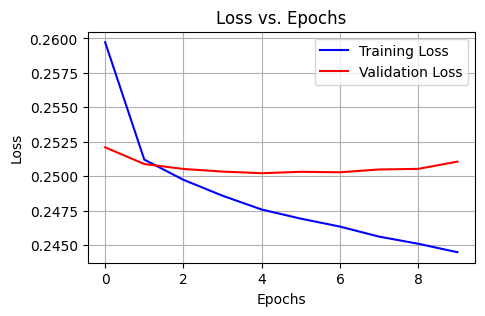

In [69]:
plt.figure(figsize=(5, 3))
plt.plot(history_sequential1.history['loss'], label='Training Loss', color='blue')
plt.plot(history_sequential1.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.grid(True)
plt.show()

#### Scaled resampled

In [70]:
model2 = Sequential([  
    Input(shape=(X_scaled_resampled.shape[1],)),  # Explicit input layer

    Dense(64, kernel_initializer='he_uniform'),
    BatchNormalization(),
    ReLU(),
    Dropout(0.05),

    Dense(32, kernel_initializer='he_uniform'),    
    ReLU(),
    Dropout(0.05),
    
    Dense(1, activation='sigmoid')
])

model2.compile(optimizer=Adam(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['AUC'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,633 (22.00 KB)

 Trainable params: 5,505 (21.50 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/10
869/869 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - AUC: 0.6681 - loss: 0.6320 - val_AUC: 0.0000e+00 - val_loss: 0.8370
Epoch 2/10
869/869 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.7376 - loss: 0.5746 - val_AUC: 0.0000e+00 - val_loss: 0.8312
Epoch 3/10
869/869 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.7454 - loss: 0.5672 - val_AUC: 0.0000e+00 - val_loss: 0.8257
Epoch 4/10
869/869 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.7503 - loss: 0.5637 - val_AUC: 0.0000e+00 - val_loss: 0.8313
Epoch 5/10
869/869 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.7543 - loss: 0.5604 - val_AUC: 0.0000e+00 - val_loss: 0.8214
Epoch 6/10
869/869 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.7574 - loss: 0.5578 - val_AUC: 0.0000e+00 - val_loss: 0.8363
Epoch 7/10
869/869 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.7601 - loss: 0.5556 - val_AUC: 0.0000e+00 - val_loss: 0.8377
Epoch 8/10
869/869 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.7645 - loss: 0.5514 - val_AUC: 0.0000e+00 - val_loss: 0.8264
Epoch 9/10
869/869 ━━━━━

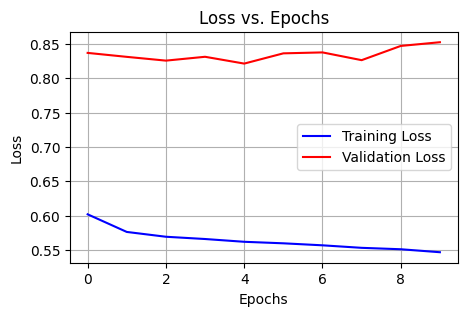

In [71]:
history_sequential = model2.fit(X_scaled_resampled, y_resampled
                               , epochs=10, batch_size=32,validation_split=0.2, verbose=1
                               ,callbacks=[early_stop])

plt.figure(figsize=(5, 3))
plt.plot(history_sequential.history['loss'], label='Training Loss', color='blue')
plt.plot(history_sequential.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [75]:
y_pred = (model.predict(X_test_scaled) > 0.5).astype(int)
y_proba = model.predict(X_test_scaled).ravel()

y_pred_train = (model.predict(X_scaled) > 0.5).astype(int)
y_pred_proba_train = model.predict(X_scaled).ravel()

# Compute metrics for train and test sets
metrics_train = get_metrics(y, y_pred_train, y_pred_proba_train)
metrics_test = get_metrics(y_test, y_pred, y_pred_proba)

metrics_df  = pd.DataFrame([metrics_train, metrics_test], index=["Train", "Test"])

# Round values for better readability
metrics_df  = metrics_df.round(4)

# Display summary table
metrics_df

2883/2883 ━━━━━━━━━━━━━━━━━━━━ 2s 756us/step
2883/2883 ━━━━━━━━━━━━━━━━━━━━ 2s 616us/step
6727/6727 ━━━━━━━━━━━━━━━━━━━━ 4s 622us/step
6727/6727 ━━━━━━━━━━━━━━━━━━━━ 4s 609us/step


,AUC-ROC,Accuracy,Precision,Recall,F1 Score
Train,0.761,0.9197,0.5951,0.0155,0.0302
Test,0.500,0.9191,0.4545,0.0121,0.0235


In [76]:
metrics_df.to_csv(FileOut+'MLP.csv')